<br />

<div style="text-align: left;">
<font size="7">Car Fuel Consumption</font>
</div>
<br />
<div style="text-align: right;">
<font size="4">Minoru katsuta ml_tokyo_9 2018-2019</font>
</div>

<br />

## 課題設定　100kmあたりのガソリン消費量を予測

#### ＜Context＞
- どんな要素がガソリンを消費するのかを予測してほしい
- SP98,E10のガソリンの種類に応じて消費量を予測してほしい

- 線形回帰モデルを試行したところ、E10では0.4リットル以上消費していた
- 線形回帰モデルは特徴量が独立している場合にしか使用できない欠点があることに留意

#### ＜Content＞
- このデータには、以下のデータが含まれている
- distance:車のディスプレイに表示される距離（km）
- consume:消費量（L/100km）
- speed:平均速度（km/h）
- temp_inside:内部温度(℃)
- temp_outside:外部温度（℃）
- specials:乗車中に以下の３つの特別なことがあった場合
- AC:エアコンをつけていた
- rain:雨が降っていた場合
- sun:天候が晴れで車のエンジンをスタートする際に温かく感じたとき
- gas_type:E10,SP98の2種類のいずれかを使用
- refill liters:どのくらいガソリンを給油したのか
- refill gas:どの種類のガソリンを給油したのか

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [3]:
df_ms1 = pd.read_csv("../1_data/measurements.csv") #CSVFileを読み込む pandasの関数}
display(df_ms1.head()) #datasetの先頭5行を表示
df_ms1.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,0,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,0,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,0,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,0,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,0,0,0,0,NaN,NaN


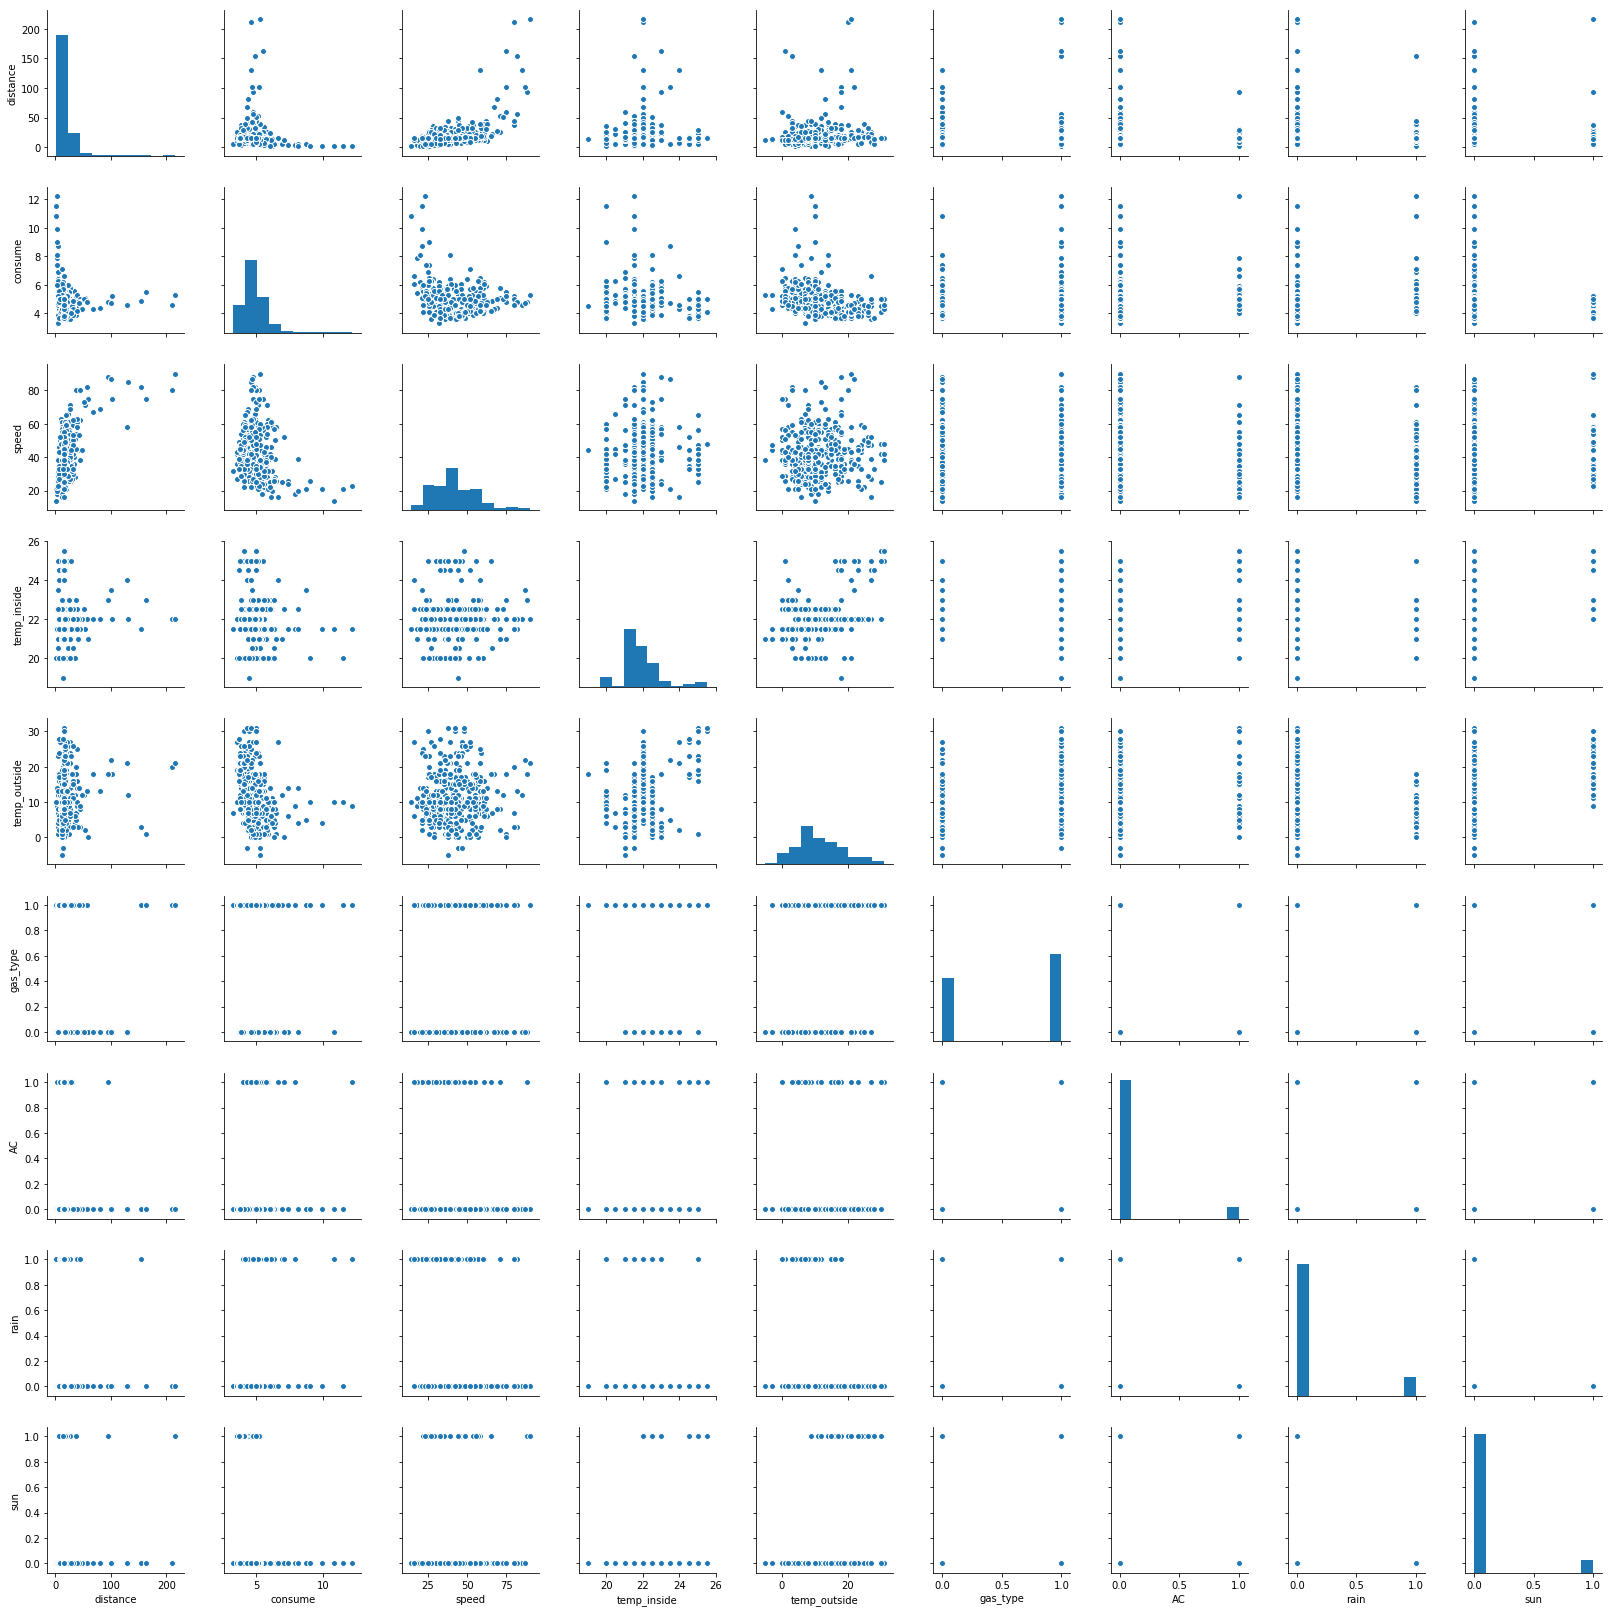

In [4]:
#gas_typeのエンコーデイング　クラスラベルと整数を対応させるディクショナリを作成
class_mapping = {label:idx for idx, label in enumerate(np.unique(df_ms1['gas_type']))} 
class_mapping = {'E10': 0, 'SP98': 1}
df_ms1['gas_type'] = df_ms1['gas_type'].map(class_mapping)
display(df_ms1.head())
cols = ['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC', 'rain', 'sun']
sns.pairplot(df_ms1[cols].dropna(), size=2.5) #Seaborn 散布図行列を作成する　欠損値は取り除く
plt.tight_layout() #matplotlibでグラフの座標が重ならないようにレイアウト調整
plt.show()

In [5]:
df_ms1[cols].corr() #ピアソンの積率相関係数を計算
#cm = np.corrcoef(df_ms1[cols].values.T) #ピアソンの積率相関係数を計算
#hm = sns.heatmap(cm,
#                 cbar=True,
#                 annot=True,
#                 square=True,
#                 fmt=' .2f',
#                 annot_kws={'size': 7},
#                 yticklabels=cols,
#                 xticklabels=cols)
#plt.tight_layout()
#plt.show()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
distance,1.000000,-0.128967,0.562299,0.075305,0.088175,-0.053411,-0.025738,-0.019791,0.081120
consume,-0.128967,1.000000,-0.227866,-0.161991,-0.320811,-0.015327,0.096591,0.248118,-0.170667
speed,0.562299,-0.227866,1.000000,0.059725,0.015411,-0.097360,-0.035408,0.009489,0.081618
temp_inside,0.075305,-0.161991,0.059725,1.000000,0.361308,0.010340,0.297775,-0.037356,0.246120
temp_outside,0.088175,-0.320811,0.015411,0.361308,1.000000,0.148705,0.167562,-0.186315,0.346903
gas_type,-0.053411,-0.015327,-0.097360,0.010340,0.148705,1.000000,0.105285,0.060328,0.022761
AC,-0.025738,0.096591,-0.035408,0.297775,0.167562,0.105285,1.000000,0.242915,0.088598
rain,-0.019791,0.248118,0.009489,-0.037356,-0.186315,0.060328,0.242915,1.000000,-0.112650
sun,0.081120,-0.170667,0.081618,0.246120,0.346903,0.022761,0.088598,-0.112650,1.000000


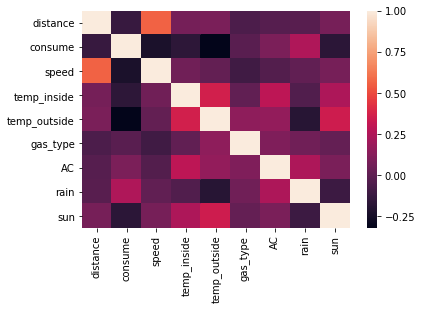

In [6]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ms1[cols].corr())
plt.show()

In [9]:
# 係数を求める
y = df_ms1.dropna()["consume"].values
X = df_ms1.dropna()[['distance', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC', 'rain', 'sun']].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5] 
w7 = regr.coef_[6]
w8 = regr.coef_[7]

In [12]:
x1 = df_ms1.dropna()['distance'].values
x2 = df_ms1.dropna()['speed'].values
x3 = df_ms1.dropna()['temp_inside'].values
x4 = df_ms1.dropna()['temp_outside'].values
x5 = df_ms1.dropna()['gas_type'].values
x6 = df_ms1.dropna()['AC'].values
x7 = df_ms1.dropna()['rain'].values
x8 = df_ms1.dropna()['sun'].values

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3 + w4 * x4 + w5 * x5 + w6 * x6 + w7 * x7 + w8 * x8
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8))
print('二乗誤差 = {:.3f}'.format(squared_error))

w0 = 5.986, w1 = -0.016, w2 = -0.013, w3 = -0.000, w4 = -0.001, w5 = -0.001, w6 = 0.000, w7 = 0.000, w8 = 0.000
二乗誤差 = 0.000
